
===

Data Challenge:

For this data science challenge, you are provided with a dataset containing mobility traces of ~500 taxi cabs in San Francisco collected over ~30 days. The format of each mobility trace file is the following - each line contains [latitude, longitude, occupancy, time], e.g.: [37.75134 -122.39488 0 1213084687], where latitude and longitude are in decimal degrees, occupancy shows if a cab has a fare (1 = occupied, 0 = free) and time is in UNIX epoch format.

The goal of this data science challenge is twofold:

1. To calculate the potential for a yearly reduction in CO2 emissions, caused by the taxi cabs roaming without passengers. In your calculation please assume that the taxicab fleet is changing at the rate of 15% per month (from combustion engine-powered vehicles to electric vehicles). Assume also that the average passenger vehicle emits about 404 grams of CO2 per mile.

2. To build a predictor for taxi drivers, predicting the next place a passenger will hail a cab.

3. (Bonus question) Identify clusters of taxi cabs that you find being relevant from the taxi cab company point of view.

===

Instructions:

Please prepare the presentation with your results. In the final presentation, you'll have to justify and explain:

1. Explanatory data analysis that you performed.

2. All the preprocessing steps that you made. Please be ready to explain any assumptions you made during the preprocessing phase.

3. Modeling techniques that you used to build your predictor

4. The metrics and methods that you used to quantify the performance of your prediction

You'll have 20 min to present (sharp), followed by Q&A session of 30 min, leaving 10 min for wrap-up and next steps.

Together with your presentation, you'll need to provide us with your source code written in Python. The best will be if you could share with us your code via GitHub - please send us an email to [1] Krzysztof.Stec@pmi.com [2] Nidhi.Singh@pmi.com and [3] Michal.Piorkowski@pmi.com when ready.

The Interviewers will be waiting for you in the call at June 17, 2022 (Friday) at 2:00 PM (Central European Summer Time).


## Imports, Global Vars etc

In [1]:
%run mlhelpers.py
%matplotlib inline

pd.set_option('display.float_format', lambda x: f'%.{len(str(x%1))-2}f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

# Q2 - predictor for taxi drivers, predicting the next place a passenger will hail a cab.

In [2]:
df_train = pd.read_csv('./data/df_train.csv')

df_train.head()

,Latitude,Longitude,DayOfWeek,HourOfDay,DayOfMonth,MinuteOfHour,Occupancy
0,37.7643899999999988,-122.4584600000000023,5.0,10.0,17.0,1.0,0
1,37.7652399999999986,-122.4543100000000067,5.0,10.0,17.0,2.0,0
2,37.7657900000000026,-122.450010000000006,5.0,10.0,17.0,3.0,0
3,37.7677600000000027,-122.4503500000000003,5.0,10.0,17.0,4.0,0
4,37.7698200000000028,-122.4487699999999961,5.0,10.0,17.0,5.0,0


In [3]:
# based on the report we can drop missing values 
print(df_train.shape)
df_train = df_train.dropna()
print(df_train.shape)

(2166684, 7)
(2166597, 7)


0    0.5529034702808137
1   0.44709652971918634
Name: Occupancy, dtype: float64


<AxesSubplot:xlabel='Occupancy', ylabel='count'>

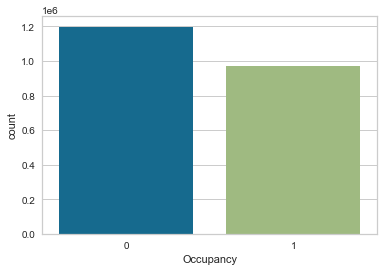

In [4]:
print(df_train['Occupancy'].value_counts(normalize=True))
sns.countplot(x='Occupancy', data=df_train)

In [5]:
# If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y))
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=df_train['Occupancy']
)

In [6]:
# All numerical columns yet - no encoding needed, later clusters might be added 
# encodeColums(df_train,cardinality_limit=40000)

In [7]:
y = df_train.Occupancy
df_train.drop(columns='Occupancy',inplace=True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, 
                                                      test_size = 0.2, random_state = 42, stratify=y)

In [24]:
# Scaling only needed for KNN but it might create distribution issues
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [25]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [26]:
y_pred = classifier.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.63      0.61    239584
           1       0.51      0.48      0.50    193736

    accuracy                           0.56    433320
   macro avg       0.56      0.55      0.55    433320
weighted avg       0.56      0.56      0.56    433320



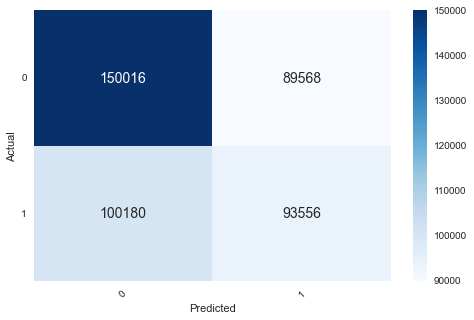

In [28]:
plot_confusion_matrix(y_test, y_pred)

### Generate test set with :
- distance 1- "maxkm" km with step of 1 km
- Start and End given lat long
- Bearing options - 0,  90, 180, 270, 360

In [14]:
def generate_test_set(start_lat=37.7643899, start_long=-122.458460000, maxkm=100, maxbearing=360):
    """Generate test given with given params"""
    test_set = []
    for d in np.random.choice(np.arange(1,maxkm+1,step=10),10):
        for b in np.arange(0,maxbearing+90,90):
            for t in np.random.choice(np.arange(0,24,1),10):
                dist=distance.distance(kilometers=d).destination((start_lat,start_long),b)
                (test_lat,test_long) = (dist[0],dist[1])
                timet = datetime(2008,5,29,10,6,30)
                test_set.append(
                    [test_lat,test_long,timet.weekday(),t,timet.day,timet.minute]
                )
    return(test_set)

In [15]:
test_set_c = generate_test_set()
classifier.predict(test_set_c)

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,

In [ ]:
visualizer = ROCAUC(classifier, classes=[0,1])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

In [21]:
results_df = pd.DataFrame(np.c_[test_set_c,classifier.predict(test_set_c)],columns=
             ['Latitude', 'Longitude', 'DayOfWeek', 'HourOfDay', 'DayOfMonth',
       'MinuteOfHour','Occupancy'])
results_df

,Latitude,Longitude,DayOfWeek,HourOfDay,DayOfMonth,MinuteOfHour,Occupancy
0,38.40404063999579876,-122.4584600000000023,3.0,10.0,29.0,6.0,1.0
1,38.40404063999579876,-122.4584600000000023,3.0,8.0,29.0,6.0,1.0
2,38.40404063999579876,-122.4584600000000023,3.0,21.0,29.0,6.0,0.0
3,38.40404063999579876,-122.4584600000000023,3.0,2.0,29.0,6.0,1.0
4,38.40404063999579876,-122.4584600000000023,3.0,18.0,29.0,6.0,1.0
...,...,...,...,...,...,...,...
495,37.7733995495899109,-122.4584600000000023,3.0,14.0,29.0,6.0,1.0
496,37.7733995495899109,-122.4584600000000023,3.0,23.0,29.0,6.0,1.0
497,37.7733995495899109,-122.4584600000000023,3.0,8.0,29.0,6.0,0.0
498,37.7733995495899109,-122.4584600000000023,3.0,2.0,29.0,6.0,1.0


In [29]:
# best_model = grid_search_xgb.best_estimator_
best_model = XGBClassifier(random_state=42, n_estimators = 100, max_depth = 5,
                           objective="binary:logistic", sample_weight=classes_weights)
best_model.fit(X_train, y_train,  eval_metric = 'auc')
y_pred = best_model.predict(X_test)

[13:57:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [32]:
# best_model.predict(test_set_c)

In [ ]:
# from sklearn.metrics import plot_roc_curve
# plot_roc_curve(classifier,X_test,y_test)

In [ ]:
## add feature is hotspot or not

### Gridsearch and other code

In [ ]:
# # "colsample_by_tree" is the fraction of features (randomly selected) that will be used to train each tree.

# param_grid = { 'n_estimators': np.arange(100,201,100),
#              'max_depth': np.arange(3,13,3)}
# # 'learning_rate': ,
# # 'colsample_bytree': np.arange(0.1,0.5,0.2),

# # objective="binary:logistic" is more applicable for one vs one 
# # In fact, even if the default obj parameter of XGBClassifier is binary:logistic, it will internally judge the number of class of label y. 
# # When the class number is greater than 2, it will modify the obj parameter to multi:softmax.
# xgb = XGBClassifier(objective="multi:softmax", random_state=42)

# grid_search_xgb = GridSearchCV(estimator = xgb, param_grid = param_grid, verbose=2,cv = 5, scoring = 'accuracy')

# grid_search_xgb.fit(X_train, y_train,  eval_metric = 'mlogloss')

# print('Best Score:', grid_search_xgb.best_score_)
# print('Parameters:', grid_search_xgb.best_params_)
# print('Best Model:', grid_search_xgb.best_estimator_)

In [ ]:
# # best_model = grid_search_xgb.best_estimator_
# best_model = XGBClassifier(random_state=42, n_estimators = 200, max_depth = 12, objective="softmax", sample_weight=classes_weights)
# best_model.fit(X_train, y_train,  eval_metric = 'auc')
# y_pred = best_model.predict(X_test)
# y_pred_train = best_model.predict(X_train)

# Deprecated

In [ ]:
# #distance.distance(unit=15).destination((lat,lon),bering) 
# dist=distance.distance(kilometers=5).destination((37.7698200000000028,-122.4487699999999961),90)
# (test_lat,test_long) = (dist[0],dist[1])
# # distance.distance(kilometers=1).destination((37.7698200000000028,-122.4487699999999961),45)
# timenow = datetime.now()
# test_data_model = [[test_lat,test_long,timenow.weekday(),timenow.hour,timenow.day,timenow.minute]]